# Examining the correlates of civilians surviving a police shooting

## IMPORTANT NOTES

1. These are simply correlations between various aspects of a shooting situation and the chance that the civilian survived. As you will see, the relationships are complex, and we do not attempt to conclude anything here -- merely describe.
1. We are exploring a LOT of hypotheses here (~20), so the p-values should not be taken literally, as they do not correct for multiple-testing. The true p-values are much higher, but since we aren't trying to conclude anything here, we won't bother to do a full multiple-testing correction.
1. It's likely that some interactions are significant (not explored here). For example, even though officer age shows no significant first-order relationship to civilian survival, it could prove significant when considered alongside race or time of day.

### PRO TIP: Just skim for the graphs if you are only interested in the results

## Hypotheses and summary of results
Hypothesized factors that may relate to survival:
- **suspect age**  [result: yes - older civilians more likely to die]
- **officer age**  [result: no]
- **suspect gender**  [result: no]
- **officer gender**  [result: no]
- **suspect race**  [result: maybe - white civilians may be more likely to die]
- **officer race**  [result: yes - incidents with black officers less likely to result in civilian death]
- **number of officers involved**  [result: maybe - may be more likely to die when multiple officers involved]
- **reason for interaction** [result: no]
- **deadly weapon present** [result: yes - civilians with deadly weapons were more likely to die]
- **type of deadly weapon** [result: yes - civilians wielding knives and guns were more likely to die]
- **time of day** [result: no]
- **day of week** [result: no]
- **county size** [result: no]

### Data quirks
1. In ~30% of incidents, demographics for multiple officers were available. For analyses having to do with the officer's race, age, etc, we only consider the first officer listed.
1. It's hard to know exactly how many officers were on scene. There is a checkbox on the form called "multiple officers involved," but in many cases where this is checked, the details for only one officer are recorded. Similarly, sometimes "multiple officers involved" is NOT checked, yet details for multiple officers exist. It's unclear what to make of this information.

### Datasets used:
* `tji/officer-involved-shootings/shot_civilians.csv`
* `tji/auxiliary-datasets/census_data_by_county`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

## I. Setup and read data

### Libary imports

In [1]:
from scipy import stats
from lib import PlotSaver, percentify_x, percentify_y, test_summary

plotsaver = PlotSaver('../plots/', 'ois_civilian_survival_')

Removing 19 past plots


/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
SNS_COLORS = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a "Everett Wetchler" -d -t -z -w -p numpy,pandas,matplotlib,datadotworld

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2018-05-16 00:26:44 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
datadotworld 1.6.0
watermark 1.5.0


### Helper code

In [3]:
def barplot_with_counts(df, x, y='civilian_died', ax=None, colors=None):
    return_fig = False
    if ax is None:
        fig, ax = plt.subplots(1)
        nx = len(set(df[x]))
        fig.set_size_inches(2 + nx, 6)
        return_fig = True

    sns.barplot(x=x, y=y, data=df, ax=ax, ci=95, capsize=.1, errwidth=1, palette=colors,
                order=list(sorted(set(c for c in df[x] if pd.notnull(c)))))

    percentify_y(ax)
    ax.set_ylabel('Odds of civilian dying')
    ax.set_xlabel('')

    counts = df[x].value_counts().sort_index()
    i = 0
    for cohort, count in counts.items():
        ax.text(i, 0.01, "N = %d" % count, color='white', horizontalalignment='center')
        i += 1

    if return_fig:
        return fig, ax

### Read data

In [4]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
shootings = datasets.dataframes['shot_civilians']
shootings.head()

,date_incident,incident_address,incident_city,incident_county,incident_zip,incident_latitude,incident_longitude,incident_result_of,incident_call_other,civilian_name_first,civilian_name_last,civilian_gender,civilian_age,civilian_race,civilian_died,officer_age_1,officer_race_1,officer_gender_1,agency_name_1,agency_report_date_1,agency_city_1,agency_county_1,agency_zip_1,agency_name_person_filling_out_1,agency_email_person_filling_out_1,officer_age_2,officer_race_2,officer_gender_2,officer_caused_injury_2,agency_name_2,agency_report_date_2,agency_city_2,agency_county_2,agency_zip_2,agency_name_person_filling_out_2,agency_email_person_filling_out_2,officer_age_3,officer_race_3,officer_gender_3,officer_caused_injury_3,agency_name_3,agency_report_date_3,agency_city_3,agency_county_3,agency_zip_3,agency_name_person_filling_out_3,agency_email_person_filling_out_3,officer_age_4,officer_race_4,officer_gender_4,...,agency_email_person_filling_out_7,officer_age_8,officer_race_8,officer_gender_8,agency_name_8,agency_report_date_8,agency_city_8,agency_county_8,agency_zip_8,agency_name_person_filling_out_8,agency_email_person_filling_out_8,officer_age_9,officer_race_9,officer_gender_9,agency_name_9,agency_report_date_9,agency_city_9,agency_county_9,agency_zip_9,agency_name_person_filling_out_9,agency_email_person_filling_out_9,officer_age_10,officer_race_10,officer_gender_10,agency_name_10,agency_report_date_10,agency_city_10,agency_county_10,agency_zip_10,agency_name_person_filling_out_10,agency_email_person_filling_out_10,news_coverage_1,news_coverage_2,news_coverage_3,news_coverage_4,cdr_narrative,custodial_death_report,deadly_weapon,deadly_weapon_category,deadly_weapon_description,extras,lea_narrative_published,lea_narrative_shorter,multiple_officers_involved,num_officers_recorded,num_reports_filed,num_rows_about_this_incident,officer_on_duty,time_incident,incident_location
0,2015-09-02,1010 MAGNOLIA STREET,FREEPORT,BRAZORIA,77541.0,28.944891,-95.356262,TRAFFIC STOP,NARCOTIC STOP AND EVADING ARREST,RICKEY,MAYBERRY,M,30.0,BLACK,False,27.0,HISPANIC,M,FREEPORT POLICE DEPT,9/16/2015,FREEPORT,BRAZORIA,77541,PAMELA MORRIS,PMORRIS@FREEPORT.TX.US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,ABC 13,YOUR SOUTHEST TEXAS,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,True,1,1,1,True,NaN,POINT(-95.3562616 28.9448909)
1,2015-09-03,4840 E. PLANO PARKWAY,PLANO,COLLIN,75074.0,33.008128,-96.642308,OTHER - SPECIFY TYPE OF CALL,ACCIDENTAL DISCHARGE RICOCHET DURING RANGE ACT...,NaN,NaN,M,55.0,WHITE,False,30.0,HISPANIC,M,PLANO POLICE DEPT,10/1/2015,PLANO,COLLIN,75074,CURTIS HOWARD,CURTISH@PLANO.GOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,(DETAILS MISSING),NaN,NaN,NaN,NaN,False,1,1,1,True,NaN,POINT(-96.6423077 33.0081284)
2,2015-09-04,101 COUCH CT.,SPRINGTOWN,PARKER,76082.0,32.916724,-97.634194,OTHER - SPECIFY TYPE OF CALL,INVESTIGATION OF CRIMINAL ACTIVITY,SULLY JOE,LANIER,M,36.0,WHITE,True,27.0,WHITE,M,PARKER CO SHERIFFS OFFICE,10/6/2015,WEATHERFORD,PARKER,76086,MEREDITH GRAY,MEREDITH.GRAY@PARKERCOUNTYTX.COM,56.0,WHITE,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,WFAA,DFW CBS LOCAL,STAR TELEGRAM,FOX 4 NEWS,DECEDENT SHOT A RIFLE AT LE OFFICERS WHOM RETU...,True,True,FIREARM,FIREARM,NaN,NaN,FIRED AT OFFICERS,True,2,1,1,True,NaN,POINT(-97.6341935 32.9167242)
3,2015-09-05,4926 CHENNAULT ROAD,HOUSTON,HARRIS,77033.0,29.681655,-95.344966,EMERGENCY CALL OR REQUEST FOR ASSISTANCE,NaN,NaN,NaN,M,21.0,BLACK,F

## II. Exploratory plots

### Age of civilian

In [5]:
def get_age_cohort(age):
    if pd.isnull(age):
        return None
    elif age < 20:
        return "0-19"
    elif age >= 50:
        return "50+"
    else:
        decade = int(age / 10) * 10
        return "%d-%d" % (decade, decade + 9)
shootings['civilian_age_cohort'] = shootings['civilian_age'].apply(get_age_cohort)

In [6]:
age_present = shootings.dropna(subset=['civilian_age'])
print("%d incidents did not record civilian age" % (len(shootings) - len(age_present)))

4 incidents did not record civilian age


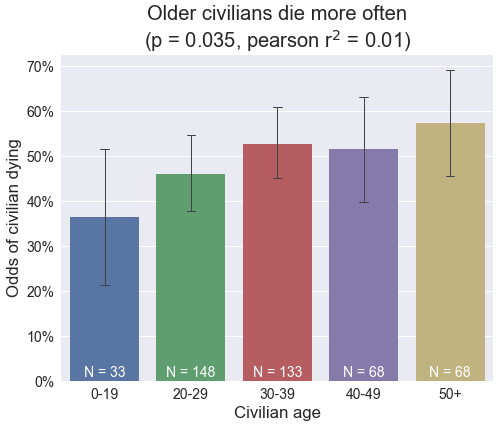

In [7]:
r, p = stats.pearsonr(age_present['civilian_age'], age_present['civilian_died'])

fig, ax = barplot_with_counts(shootings, 'civilian_age_cohort')
ax.set_title('Older civilians die more often\n' + test_summary(p, r=r))
ax.set_xlabel('Civilian age')
fig.set_size_inches(10, 6)
plt.subplots_adjust(left=0.2, right=0.8)
plotsaver.saveplot(fig, 'civilian_age')
pass

### Age of officer

In [8]:
def get_officer_age_cohort(age):
    if pd.isnull(age):
        return None
    elif age < 25:
        return "18-24"
    elif age >= 40:
        return "50+"
    else:
        age_bin = int(age / 5) * 5
        return "%d-%d" % (age_bin, age_bin + 4)

age_present = shootings.dropna(subset=['officer_age_1'])
print("%d incidents did not record officer age" % (len(shootings) - len(age_present)))
age_present['officer_age_cohort_1'] = age_present['officer_age_1'].apply(get_officer_age_cohort)

0 incidents did not record officer age


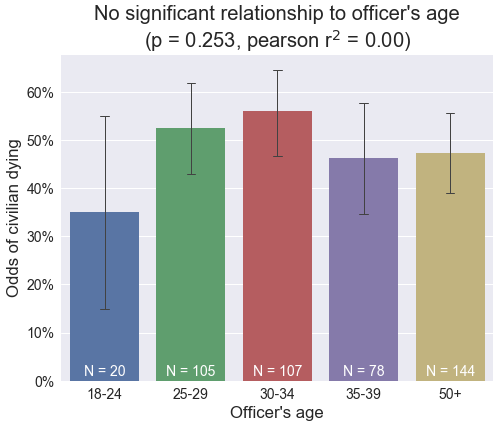

In [9]:
r, p = stats.pearsonr(age_present['officer_age_1'], age_present['civilian_died'])

fig, ax = barplot_with_counts(age_present, 'officer_age_cohort_1')
ax.set_title('No significant relationship to officer\'s age\n' + test_summary(p, r=r))
ax.set_xlabel('Officer\'s age')
fig.set_size_inches(10, 6)
plt.subplots_adjust(left=0.2, right=0.8)
plotsaver.saveplot(fig, 'officer_age')
pass

### Sex of civilian

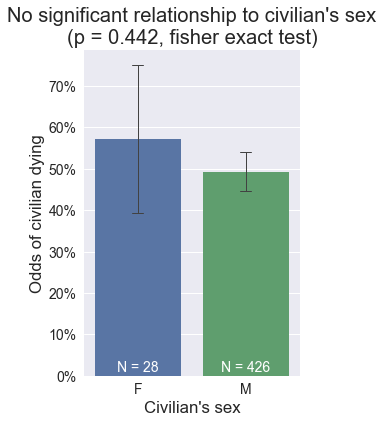

In [10]:
table = pd.crosstab(shootings['civilian_gender'], shootings['civilian_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'civilian_gender')
ax.set_title("No significant relationship to civilian's sex\n" + test_summary(p, fisher=True))
ax.set_xlabel("Civilian's sex")
fig.set_size_inches(10, 6)
plt.subplots_adjust(left=0.35, right=0.65)
plotsaver.saveplot(fig, 'civilian_sex')
pass

### Sex of officer

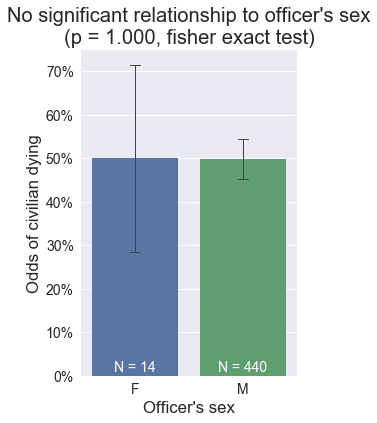

In [11]:
table = pd.crosstab(shootings['officer_gender_1'], shootings['civilian_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'officer_gender_1')
ax.set_title("No significant relationship to officer's sex\n" + test_summary(p, fisher=True))
ax.set_xlabel("Officer's sex")
fig.set_size_inches(10, 6)
plt.subplots_adjust(left=0.35, right=0.65)
plotsaver.saveplot(fig, 'officer_sex')
pass

### Race of civilian

In [12]:
shootings['civilian_race'].value_counts()

WHITE       171
HISPANIC    154
BLACK       120
OTHER         9
Name: civilian_race, dtype: int64

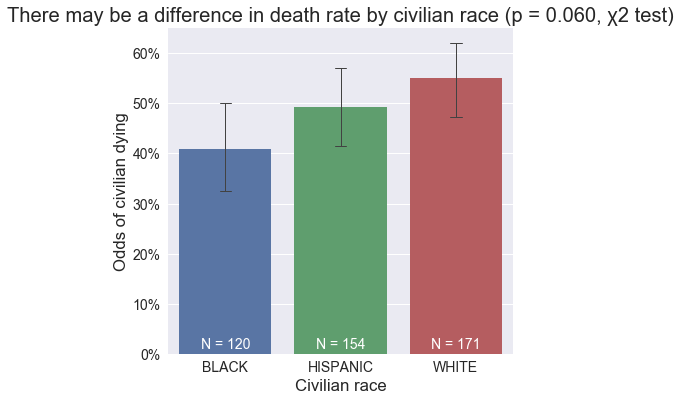

In [13]:
top3_races_civilian = shootings[shootings['civilian_race'] != 'OTHER']

table = pd.crosstab(top3_races_civilian['civilian_race'], top3_races_civilian['civilian_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(top3_races_civilian, 'civilian_race')

ax.set_title("There may be a difference in death rate by civilian race " + test_summary(p, chi=True))
ax.set_xlabel('Civilian race')

fig.set_size_inches(12, 6)
plt.subplots_adjust(left=0.3, right=0.7)
plotsaver.saveplot(fig, 'civilian_race')
pass

### Race of officer

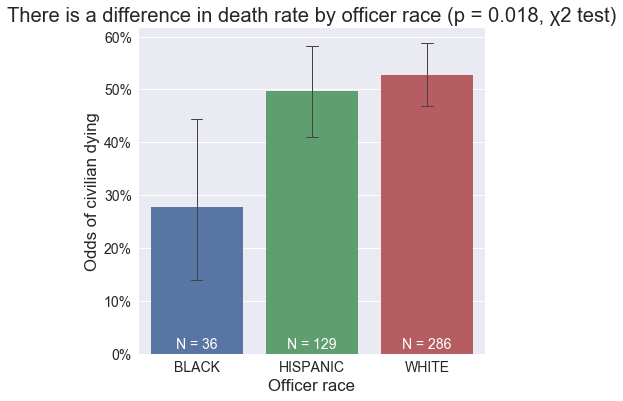

In [14]:
top3_races_officer = shootings[shootings['officer_race_1'] != 'OTHER']

table = pd.crosstab(top3_races_officer['officer_race_1'], top3_races_officer['civilian_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(top3_races_officer, 'officer_race_1')

ax.set_title("There is a difference in death rate by officer race " + test_summary(p, chi=True))
ax.set_xlabel('Officer race')
fig.set_size_inches(12, 6)
plt.subplots_adjust(left=0.3, right=0.7)
plotsaver.saveplot(fig, 'officer_race')
pass

### Interaction of officer and civilian race

In [15]:
top3_races_both = shootings[(shootings['officer_race_1'] != 'OTHER') &
                            (shootings['civilian_race'] != 'OTHER')]
print("Ignoring %d of %d incidents where officer and civilian races were not both one of {white, black, or hispanic}" % (
    len(shootings) - len(top3_races_both), len(shootings)))
print()

Ignoring 12 of 454 incidents where officer and civilian races were not both one of {white, black, or hispanic}



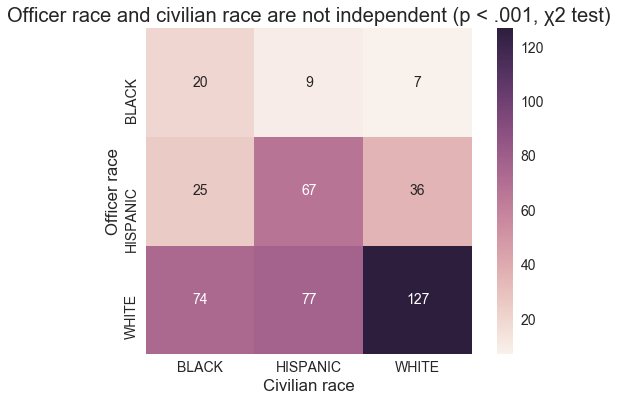

In [16]:
counts = top3_races_both.groupby(['officer_race_1', 'civilian_race']).size().unstack()
p = stats.chi2_contingency(counts)[1]
fig, ax = plt.subplots(1)
# fig.set_size_inches(6, 6)
sns.heatmap(counts, annot=True, square=True, fmt="d", ax=ax)
ax.set_ylabel('Officer race')
ax.set_xlabel('Civilian race')
ax.set_title("Officer race and civilian race are not independent " + test_summary(p, chi=True))
plotsaver.saveplot(fig, 'race_heatmap')

### Breakout by officer race

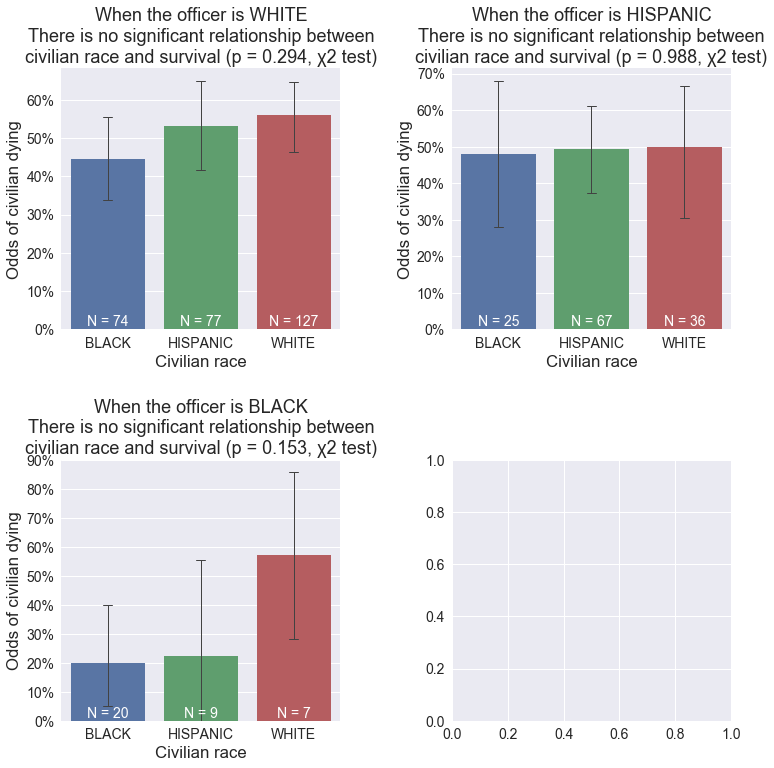

In [17]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
axes = axes.flatten()

for i in range(3):
    race = ('WHITE', 'HISPANIC', 'BLACK')[i]
    ax = axes[i]
    this_race = top3_races_civilian[top3_races_civilian['officer_race_1'] == race]

    table = pd.crosstab(this_race['civilian_race'], this_race['civilian_died'])
    p = stats.chi2_contingency(table)[1]

    barplot_with_counts(this_race, 'civilian_race', ax=ax)

    ax.set_title("When the officer is %s\nThere is no significant relationship "
                 "between\ncivilian race and survival " % race + test_summary(p, chi=True),
                fontsize=18)
    ax.set_xlabel('Civilian race')
    pass

plt.subplots_adjust(hspace=0.5, wspace=0.4)
plotsaver.saveplot(fig, 'officer_race_breakout')

### Number of officers recorded

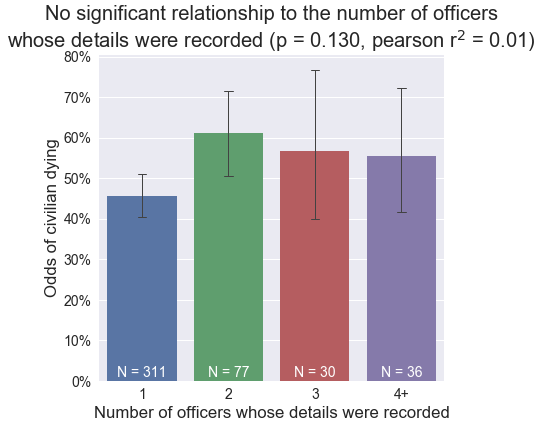

In [18]:
def get_num_officers_bucket(n):
    if n > 3:
        return "4+"
    return str(n)

shootings['num_officers_recorded_bucket'] = shootings['num_officers_recorded'].apply(get_num_officers_bucket)

r, p = stats.pearsonr(shootings['num_officers_recorded'], shootings['civilian_died'])

fig, ax = barplot_with_counts(shootings, 'num_officers_recorded_bucket')
ax.set_title('No significant relationship to the number of officers\nwhose details were recorded ' + test_summary(p, r=r))
ax.set_xlabel('Number of officers whose details were recorded')
fig.set_size_inches(8, 6)
plt.subplots_adjust(left=0.2, right=0.8)
plotsaver.saveplot(fig, 'num_officers')
pass

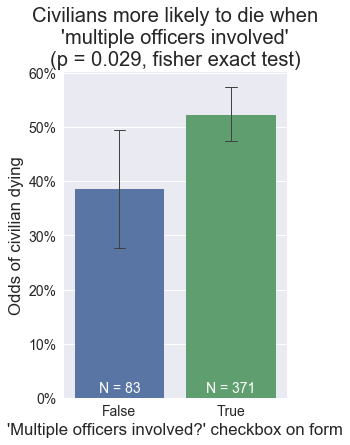

In [19]:
table = pd.crosstab(shootings['multiple_officers_involved'], shootings['civilian_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'multiple_officers_involved')
ax.set_title("Civilians more likely to die when\n'multiple officers involved'\n" + test_summary(p, fisher=True))
ax.set_xlabel("'Multiple officers involved?' checkbox on form")
fig.set_size_inches(4, 6)
# plt.subplots_adjust(left=0.35, right=0.65)
plotsaver.saveplot(fig, 'multiple_officers')
pass

### Reason for the encounter

In [20]:
shootings['incident_result_of'].value_counts()

EMERGENCY CALL OR REQUEST FOR ASSISTANCE                                                      185
OTHER - SPECIFY TYPE OF CALL                                                                  138
TRAFFIC STOP                                                                                   42
HOSTAGE, BARRICADE, OR OTHER EMERGENCY SITUATION                                               39
EXECUTION OF A WARRANT                                                                         39
EMERGENCY CALL OR REQUEST FOR ASSISTANCE, TRAFFIC STOP                                          4
EMERGENCY CALL OR REQUEST FOR ASSISTANCE; HOSTAGE, BARRICADE, OR OTHER EMERGENCY SITUATION      4
EMERGENCY                                                                                       2
HOSTAGE, BARRICADE, OR OTHER EMERGENCY SITUATION; OTHER - SPECIFY TYPE OF CALL                  1
Name: incident_result_of, dtype: int64

In [21]:
limited_reasons = {
    'EMERGENCY CALL OR REQUEST FOR ASSISTANCE': 'CALL',
    'EXECUTION OF A WARRANT': 'EXECUTING\nWARRANT',
    'TRAFFIC STOP': 'TRAFFIC\nSTOP'
}

In [22]:
shootings['incident_result_of_limited'] = shootings['incident_result_of'].apply(
    lambda r: limited_reasons.get(r, 'OTHER'))
shootings['incident_result_of_limited'].value_counts()

OTHER                 188
CALL                  185
TRAFFIC\nSTOP          42
EXECUTING\nWARRANT     39
Name: incident_result_of_limited, dtype: int64

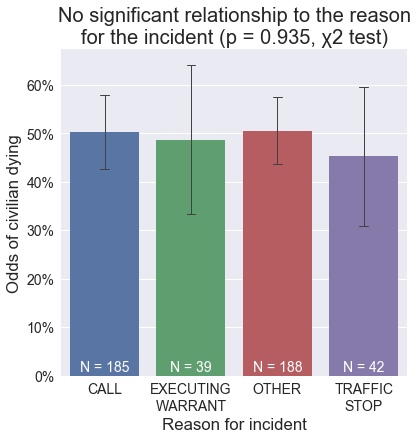

In [23]:
table = pd.crosstab(shootings['incident_result_of_limited'], shootings['civilian_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(shootings, 'incident_result_of_limited')

ax.set_title("No significant relationship to the reason\nfor the incident " + test_summary(p, chi=True))
ax.set_xlabel('Reason for incident')
fig.set_size_inches(8, 6)
plt.subplots_adjust(left=0.2, right=0.8)
plotsaver.saveplot(fig, 'incident_reason')
pass

### Civilian wielded deadly weapon

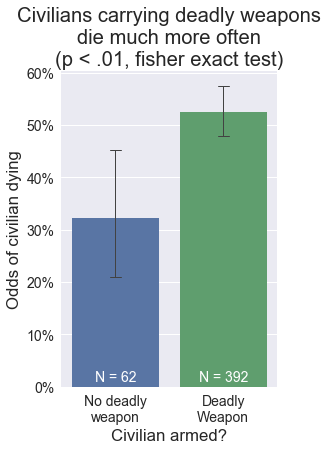

In [24]:
table = pd.crosstab(shootings['deadly_weapon'], shootings['civilian_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'deadly_weapon')

ax.set_title("Civilians carrying deadly weapons\ndie much more often\n" + test_summary(p, fisher=True))
ax.set_xticklabels(['No deadly\nweapon', 'Deadly\nWeapon'])
ax.set_xlabel("Civilian armed?")
fig.set_size_inches(6, 6)
plt.subplots_adjust(left=0.25, right=0.75, bottom=0.15)
plotsaver.saveplot(fig, 'deadly_weapon')
pass

### Type of deadly weapon

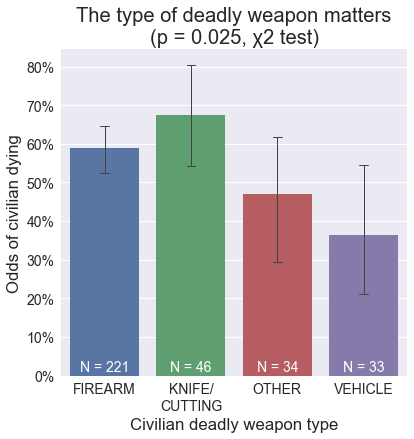

In [25]:
deadly_weapon = shootings[shootings['deadly_weapon']]
deadly_weapon = deadly_weapon[deadly_weapon['deadly_weapon_category'] != '(DETAILS MISSING)']
table = pd.crosstab(deadly_weapon['deadly_weapon_category'], shootings['civilian_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(deadly_weapon, 'deadly_weapon_category')

ax.set_title("The type of deadly weapon matters\n" + test_summary(p, chi=True))
ax.set_xticklabels(['/\n'.join(t.get_text().split('/')) for t in ax.get_xticklabels()])
ax.set_xlabel("Civilian deadly weapon type")
fig.set_size_inches(8, 6)
plt.subplots_adjust(left=0.2, right=0.8)
plotsaver.saveplot(fig, 'deadly_weapon_type')
pass

### Are all races equally likely to have a deadly weapon?

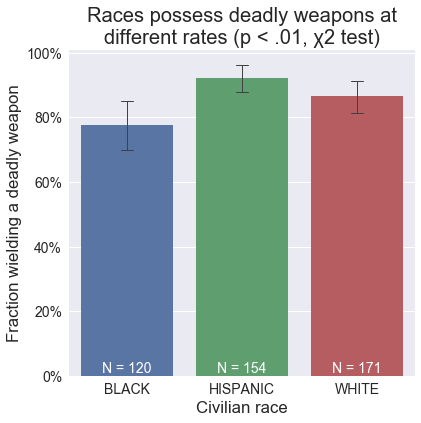

In [26]:
table = pd.crosstab(top3_races_civilian['civilian_race'], top3_races_civilian['deadly_weapon'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(top3_races_civilian, 'civilian_race', 'deadly_weapon')

ax.set_title("Races possess deadly weapons at\ndifferent rates " + test_summary(p, chi=True))
ax.set_ylabel("Fraction wielding a deadly weapon")
ax.set_xlabel("Civilian race")
fig.set_size_inches(8, 6)
plt.subplots_adjust(left=0.2, right=0.8)
plotsaver.saveplot(fig, 'deadly_weapon_by_race')
pass

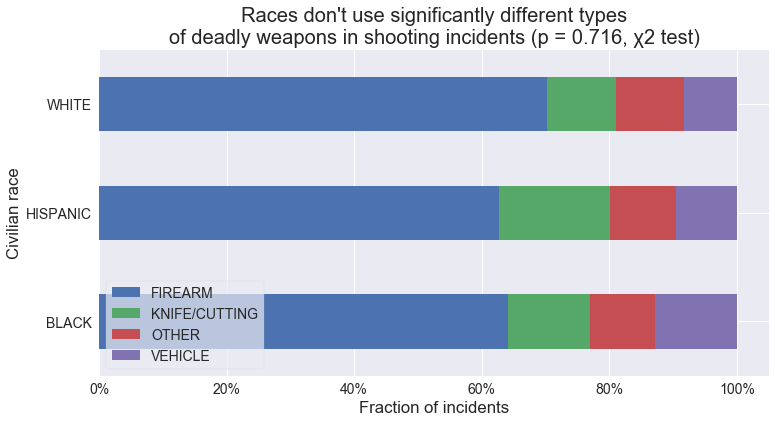

In [27]:
frame = top3_races_civilian[top3_races_civilian['deadly_weapon_category'] != '(DETAILS MISSING)']
table = frame.groupby(['civilian_race', 'deadly_weapon_category']).size().unstack()
p = stats.chi2_contingency(table)[1]

table = table.div(table.sum(axis=1), axis=0)

fig, ax = plt.subplots(1)
table.plot(kind='barh', stacked=True, ax=ax)
ax.legend(loc='lower left')
ax.set_ylabel('Civilian race')
ax.set_xlabel('Fraction of incidents')
percentify_x(ax)
ax.set_title("Races don't use significantly different types\nof deadly weapons in shooting incidents " + test_summary(p, chi=True))
fig.set_size_inches(12, 6)
# plt.subplots_adjust(left=0.3, right=0.7)
plotsaver.saveplot(fig, 'deadly_weapon_type_by_race')
pass

### Time of day

In [28]:
has_time_of_day = shootings[shootings['time_incident'].notnull()]
print(f"Ignoring {len(shootings) - len(has_time_of_day)} of {len(shootings)} incidents that did not record a time of day")

Ignoring 142 of 454 incidents that did not record a time of day


/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


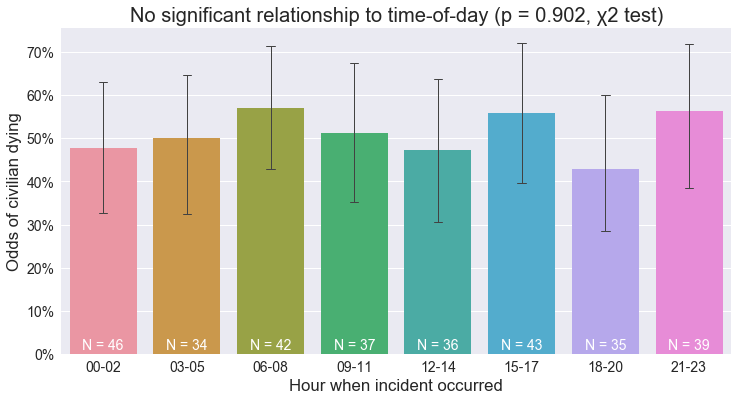

In [29]:
def get_time_of_day_bucket(t):
    bin_size = 3
    mod = 24 // bin_size
    r = int(t[:2]) % mod
    return "%02d-%02d" % (r * bin_size, (r + 1) * bin_size - 1)
    
has_time_of_day['time_of_day_bucket'] = has_time_of_day['time_incident'].apply(get_time_of_day_bucket)

table = pd.crosstab(has_time_of_day['time_of_day_bucket'], has_time_of_day['civilian_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(has_time_of_day, 'time_of_day_bucket')

ax.set_title("No significant relationship to time-of-day " + test_summary(p, chi=True))
ax.set_xlabel('Hour when incident occurred')
fig.set_size_inches(12, 6)
# plt.subplots_adjust(left=0.3, right=0.7)
plotsaver.saveplot(fig, 'time_of_day')
pass

### Day of week

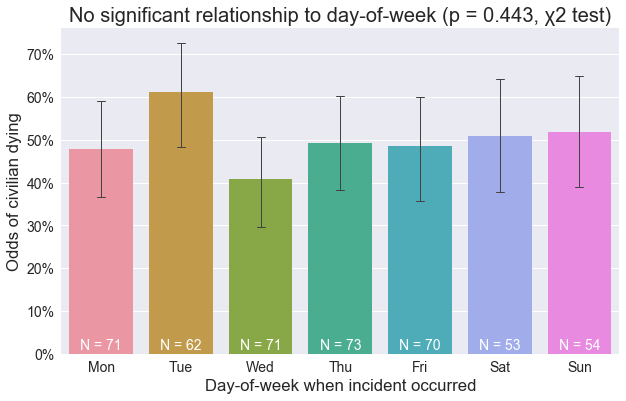

In [30]:
shootings['weekday'] = shootings['date_incident'].apply(lambda d: d.weekday())

table = pd.crosstab(shootings['weekday'], shootings['civilian_died'])
p = stats.chi2_contingency(table)[1]

fig, ax = barplot_with_counts(shootings, 'weekday')

ax.set_title("No significant relationship to day-of-week " + test_summary(p, chi=True))
ax.set_xlabel('')
ax.set_xticklabels('Mon Tue Wed Thu Fri Sat Sun'.split())
ax.set_xlabel('Day-of-week when incident occurred')
fig.set_size_inches(10, 6)
# plt.subplots_adjust(left=0.3, right=0.7)
plotsaver.saveplot(fig, 'day_of_week')
pass

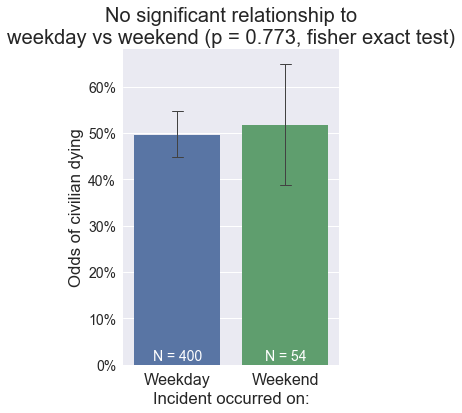

In [31]:
shootings['is_weekend'] = shootings['date_incident'].apply(lambda d: d.weekday() >= 6)

table = pd.crosstab(shootings['is_weekend'], shootings['civilian_died'])
p = stats.fisher_exact(table)[1]

fig, ax = barplot_with_counts(shootings, 'is_weekend')

ax.set_title("No significant relationship to\nweekday vs weekend " + test_summary(p, fisher=True))
ax.set_xlabel('Incident occurred on:')
ax.set_xticklabels(['Weekday', 'Weekend'], fontsize=16)
fig.set_size_inches(6, 6)
plt.subplots_adjust(left=0.25, right=0.75, bottom=0.15)
plotsaver.saveplot(fig, 'weekend')
pass

### County size

In [32]:
print("Reading from data.world")
datasets = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
census = datasets.dataframes['census_data_by_county']

Reading from data.world


In [33]:
county_populations = census[census['metric_description'] == 'Population estimates, July 1, 2016,  (V2016)'].iloc[0]
county_populations.drop(['metric_category', 'metric_subcategory', 'metric_description', 'all_texas'], inplace=True)
county_populations = county_populations.astype(int).to_dict()

In [34]:
def get_population_bin(p):
    if p >= 1e6:
        return '1MM+'
    elif p >= 1e5:
        return '100k-1MM'
    elif p >= 1e4:
        return '10k-100k'
    else:
        return '<10k'

In [35]:
shootings['incident_county_pop'] = shootings.incident_county.apply(
    lambda c: county_populations.get('_'.join(c.lower().split()), np.nan))
valid_counties = shootings.dropna(subset=['incident_county_pop'])
print("Ignoring %d incidents from unrecognized counties (likely bordering states)" % (
    len(shootings) - len(valid_counties)))
valid_counties['log_incident_county_pop'] = valid_counties['incident_county_pop'].apply(np.log10)
valid_counties['log_incident_county_pop_rounded'] = valid_counties['log_incident_county_pop'].astype(int)

Ignoring 2 incidents from unrecognized counties (likely bordering states)


/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


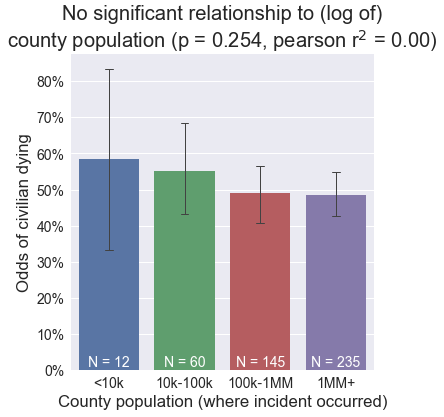

In [36]:
r, p = stats.pearsonr(valid_counties['log_incident_county_pop'], valid_counties['civilian_died'])

fig, ax = barplot_with_counts(valid_counties, 'log_incident_county_pop_rounded')
ax.set_title('No significant relationship to (log of)\ncounty population ' + test_summary(p, r=r))
ax.set_xlabel('County population (where incident occurred)')
ax.set_xticklabels(['<10k', '10k-100k', '100k-1MM', '1MM+'])
fig.set_size_inches(7, 6)
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.15)
plotsaver.saveplot(fig, 'county_population')
pass